In [ ]:
# drive dosya erişim
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Kütüphanleri indir
#!pip install tensorflow
#!pip install keras

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import DenseNet121
from keras.metrics import Precision, Recall

In [ ]:
# Sınıflandırma
precision = Precision()
recall = Recall()
classes_names = [
    "azami_hiz_60",
    "azami_hiz_70",
    "azami_hiz_80",
    "bisiklet_gecebilir",
    "bisiklet_yolu",
    "duraklamak_ve_park_etmek_yasak",
    "girilmez",
    "motorlu_tasit_yolu_baslangici",
    "motorlu_tasit_yolu_sonu",
    "okul_gecidi",
    "saga_donus",
    "saga_donus_yasak",
    "sesli_ikaz_cihazi_kullanimi_yasak",
    "u_donusu_yapilir"
]

In [ ]:
# Veri setinin yolu
train_data_dir = r"/content/drive/MyDrive/proje-b_dataset/train"
test_data_dir = r"/content/drive/MyDrive/proje-b_dataset/test"
valid_data_dir = r"/content/drive/MyDrive/proje-b_dataset/validation"

In [ ]:
# Veri ön işleme ve augmentasyon için ImageDataGenerator kullanma
train_datagen = ImageDataGenerator(
    rotation_range=20,
    rescale=1./255,
    shear_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.2, 1.5], # Kontrast ve parlaklık ayarı
    width_shift_range=0.15,  # Yatay kaydırma
    height_shift_range=0.15,  # Dikey kaydırma
    zoom_range=0.1,  # Ölçeklendirme
    channel_shift_range=10.0  # Düşük yoğunluklu Gaussian gürültü
    )

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Veri setlerini yükleyerek ImageDataGenerator nesneleri olusturma
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

Found 1890 images belonging to 14 classes.


In [ ]:
#valid generator
validation_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

Found 420 images belonging to 14 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
test_data_dir,
target_size=(128, 128),
batch_size=64,
class_mode='categorical',
shuffle=True
)


Found 406 images belonging to 14 classes.


In [ ]:
#densenet model oluşturma
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))#densenet modelini yukler

# Sadece eklenen katmanların eğitilmesini sağlama
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(len(classes_names), activation="softmax"))#14 sinif oldugu icin len(classes_names) tane noron ekledik
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               5

In [ ]:
# Modeli derleme
model.compile(optimizer=Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

#Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00005, verbose=1)#egitim esnasinda ogrenme oranini dinamik olarak ayarlar

# Model Checkpoint
checkpoint = ModelCheckpoint('best_model_densenet.h5', verbose=1, save_best_only=True, monitor='val_loss')#model egitimi esnasinda en iyi genelleme yapan agirliklari kaydeder


In [ ]:
# Modeli eğitme
history = model.fit(
train_generator,
epochs=100,
validation_data=validation_generator,
batch_size=64,
callbacks=[reduce_lr, checkpoint],
shuffle=True
)

Epoch 1/100
30/30 [==============================] - ETA: 0s - loss: 0.4984 - accuracy: 0.8413 - precision: 0.9013 - recall: 0.7968 
Epoch 1: val_loss improved from inf to 2.90602, saving model to best_model_densenet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 807s 26s/step - loss: 0.4984 - accuracy: 0.8413 - precision: 0.9013 - recall: 0.7968 - val_loss: 2.9060 - val_accuracy: 0.5690 - val_precision: 0.5718 - val_recall: 0.5690 - lr: 0.0050
Epoch 2/100
30/30 [==============================] - ETA: 0s - loss: 0.1320 - accuracy: 0.9524 - precision: 0.9614 - recall: 0.9481
Epoch 2: val_loss improved from 2.90602 to 1.17600, saving model to best_model_densenet.h5
30/30 [==============================] - 160s 5s/step - loss: 0.1320 - accuracy: 0.9524 - precision: 0.9614 - recall: 0.9481 - val_loss: 1.1760 - val_accuracy: 0.7333 - val_precision: 0.7386 - val_recall: 0.7333 - lr: 0.0050
Epoch 3/100
30/30 [==============================] - ETA: 0s - loss: 0.1120 - accuracy: 0.9614 - precision: 0.9679 - recall: 0.9561
Epoch 3: val_loss improved from 1.17600 to 0.57929, saving model to best_model_densenet.h5
30/30 [==============================] - 158s 5s/step - loss: 0.1120 - accuracy: 0.9614 - precision: 0.

In [ ]:
#model kaydetme
model.save_weights('best_model_resnet_50_new_data.h5')

#model yukleme
model.load_weights("best_model_resnet_50_new_data.h5")

In [ ]:
# Model performansini degerlendirme
evaluation = model.evaluate((test_generator), steps=len(test_generator))
print("Test veri seti üzerinde modelin performansı: Loss={}, Accuracy={}, Precision={}, Recall={}".format(evaluation[0], evaluation[1], evaluation[2], evaluation[3]))

7/7 [==============================] - 142s 23s/step - loss: 0.0167 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9901
Test veri seti üzerinde modelin performansı: Loss=0.01668918877840042, Accuracy=0.9926108121871948, Precision=0.9925925731658936, Recall=0.9901477694511414


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'lr'])


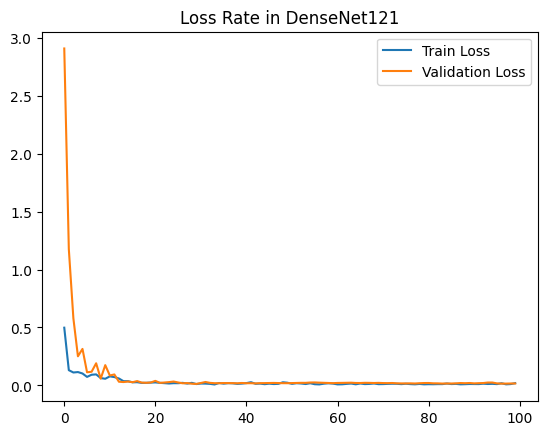

In [ ]:
#gorsellestirme
import matplotlib.pyplot as plt

print(history.history.keys())
plt.title("Loss Rate in DenseNet121")
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
#loss ve accuracy Train uzerinde, val_loss ve val_accuracy Test uzerindeki sonuclar
plt.legend()
plt.show()

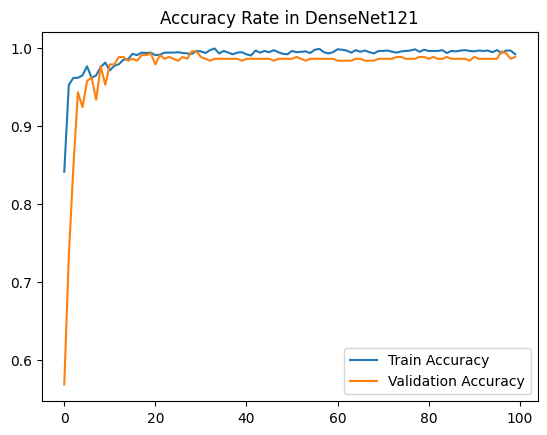

In [ ]:
plt.figure()
plt.title("Accuracy Rate in DenseNet121")
plt.plot(history.history["accuracy"], label = "Train Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.legend()
plt.show()

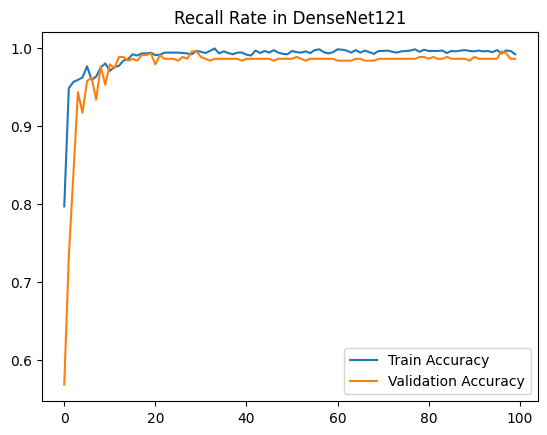

In [ ]:
plt.figure()
plt.title("Recall Rate in DenseNet121")
plt.plot(history.history["recall"], label = "Train Accuracy")
plt.plot(history.history["val_recall"], label = "Validation Accuracy")
plt.legend()
plt.show()

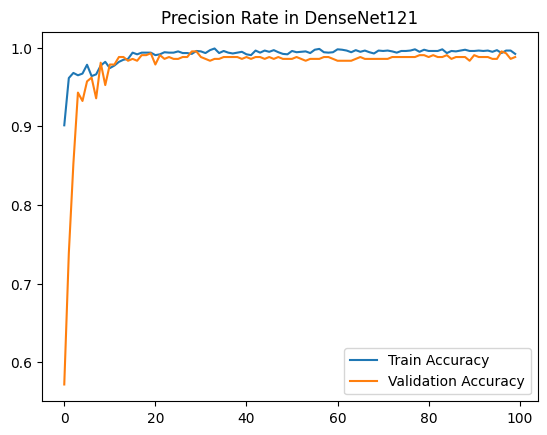

In [ ]:
plt.figure()
plt.title("Precision Rate in DenseNet121")
plt.plot(history.history["precision"], label = "Train Accuracy")
plt.plot(history.history["val_precision"], label = "Validation Accuracy")
plt.legend()
plt.show()


In [ ]:
# Model performansini degerlendirme
evaluation = model.evaluate((test_generator), steps=len(test_generator))
print("Test veri seti üzerinde modelin performansı: Loss={}, Accuracy={}, Precision={}, Recall={}".format(evaluation[0], evaluation[1], evaluation[2], evaluation[3]))





7/7 [==============================] - 27s 3s/step - loss: 0.0167 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9901
Test veri seti üzerinde modelin performansı: Loss=0.01668919064104557, Accuracy=0.9926108121871948, Precision=0.9925925731658936, Recall=0.9901477694511414


In [ ]:
#tahmin etme
import numpy as np
from keras.models import load_model
from tensorflow.keras.preprocessing import image

class_labels = [
    "azami_hiz_60",
    "azami_hiz_70",
    "azami_hiz_80",
    "bisiklet_gecebilir",
    "bisiklet_yolu",
    "duraklamak_ve_park_etmek_yasak",
    "girilmez",
    "motorlu_tasit_yolu_baslangici",
    "motorlu_tasit_yolu_sonu",
    "okul_gecidi",
    "saga_donus",
    "saga_donus_yasak",
    "sesli_ikaz_cihazi_kullanimi_yasak",
    "u_donusu_yapilir"
]

#onceden egitilen modeli yukleme
model = load_model('best_model_densenet.h5')

#goruntuyu okuma ve veri on isleme yapma
img_path = r"/content/N.png"  # Test resminin yolu
img = image.load_img(img_path, target_size=(128, 128))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

# Tahmin yapma
predictions = model.predict(x)#tahminde bulunma
predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]

print("Tahmin edilen sınıf:", predicted_class)

1/1 [==============================] - 3s 3s/step
Tahmin edilen sınıf: girilmez
